In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from fbprophet import Prophet

%matplotlib inline
%config Completer.use_jedi = False

Согласно статье Facebook Prophet, был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, библиотека дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.


Давайте немного обсудим, как же работает библиотека Prophet. По сути, это additive regression model, состоящая из следующих компонент:


$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$


Сезонные компоненты $s(t)$ отвечают за моделирование периодических изменений, связанных с недельной и годовой сезонностью. Недельная сезонность моделируется с помощью dummy variables. Добавляются 6 дополнительных признаков, например, [monday, tuesday, wednesday, thursday, friday, saturday], которые принимают значения 0 и 1 в зависимости от даты. Признак sunday, соответствующий седьмому дню недели, не добавляют, потому что он будут линейно зависеть от других дней недели и это будет влиять на модель.
Годовая же сезонность моделируется рядами Фурье.
Тренд $g(t)$ — это кусочно-линейная или логистическая функция. С линейной функцией все понятно. Логистическая же функция вида $g(t) = \frac{C}{1+exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. Типичный пример — это рост аудитории приложения или сайта.
Кроме всего прочего, библиотека умеет по историческим данным выбирать оптимальные точки изменения тренда. Но их также можно задать и вручную (например, если известны даты релизов новой функциональности, которые сильно повлияли на ключевые показатели).
Компонента $h(t)$ отвечает за заданные пользователем аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.

Видно, что Prophet выигрывает у остальных методов и меньше ошибается.

In [2]:
from PIL import Image
img = Image.open('prophet_comparrison.png')
img

In [3]:
df_full = pd.read_csv('data/df_full_clean.csv')

In [4]:
df_full['utc_event_time'] = pd.to_datetime(df_full['utc_event_time'])
df_full['utc_event_date'] = pd.to_datetime(df_full['utc_event_date'])

In [5]:
df_purchase = df_full.query('ecom_event_action == "purchase"')

In [6]:
# Видно пики по часам. 2 Пика возможно потому что регионы России расположены в разных часовых поясах (до 8 часов разницы)
# И это 2 пика, скажем, локально в 8 вечера в каждом регионе
df_purchase['utc_event_time'].dt.hour.hist()

<AxesSubplot:>

<AxesSubplot:>

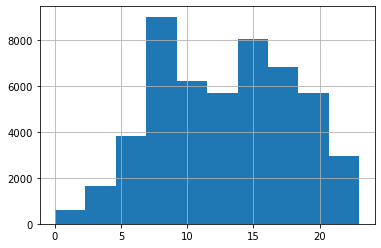

In [7]:
# Гипотеза не подтвердилась. В Москве также есть 2 пика по часам. Значит большинство продаж происходит в 9 утра и 15 дня
df_purchase.query('city_name == "Москва"')['utc_event_time'].dt.hour.hist()

In [8]:
grp_daily_sales_qty = df_purchase.groupby('utc_event_date', as_index=False) \
                                .agg({'ecom_qty': 'sum'})

In [9]:
import holidays
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RU(years=(2021, 2022))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

ds    holiday
0 2021-01-01  Новый год
1 2021-01-02  Новый год
2 2021-01-03  Новый год
3 2021-01-04  Новый год
4 2021-01-05  Новый год

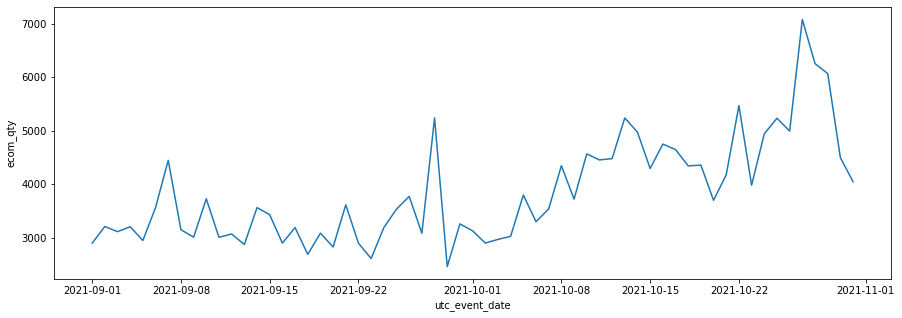

In [10]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=grp_daily_sales_qty, x='utc_event_date', y='ecom_qty');

In [11]:
grp_daily_sales_for_prophet = grp_daily_sales_qty.rename(columns={'utc_event_date': 'ds', 
                                                                  'ecom_qty': 'y'})

In [12]:
# Период, который нам надо отрезать и предсказать (проверка модели)
predictions = 14

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = grp_daily_sales_for_prophet[:-predictions]
train_df.tail()

ds     y
42 2021-10-13  5239
43 2021-10-14  4973
44 2021-10-15  4296
45 2021-10-16  4752
46 2021-10-17  4650

In [13]:
# Настраиваем prophet - говорим ему учитывать праздники и сезонности
# Поскольку данные всего за 2 месяца, к сожалению, нельзя добавить годовую сезонность
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.fit(train_df)

In [14]:
# Предсказываем 30 дней
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

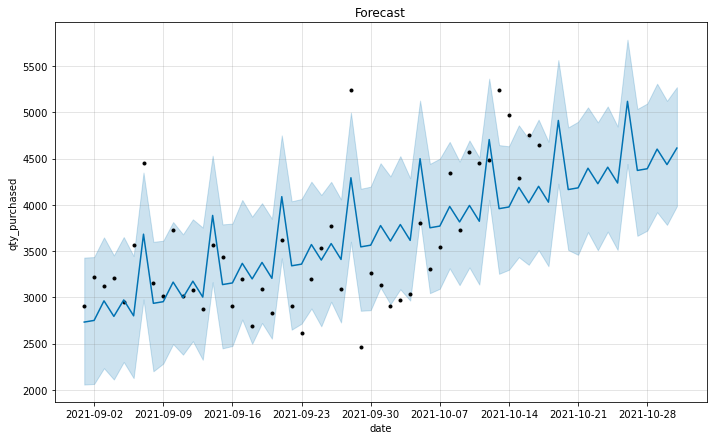

In [23]:
m.plot(forecast)
plt.title('Forecast')
plt.xlabel('date')
plt.ylabel('qty_purchased');

Тренд восходящий    
Фактор праздников не задетектил скачков (потому что бралась открытая библиотека, где мало тематических событий и нет негосударственных общепринятых событий, которые значительно влияют на продажи - Черная Пятница, День Святого Валентина...). Если собрать более полные данные о праздниках и событиях, то можно значительно улучшить модель.   
Есть сезонность внутри недели.

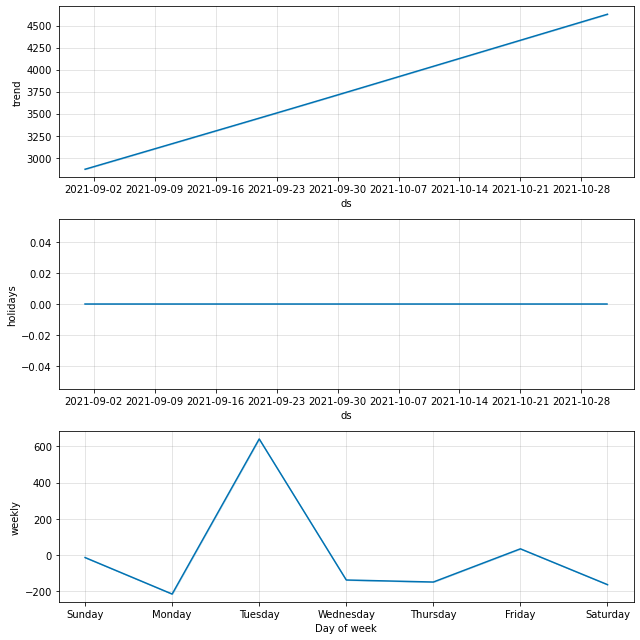

In [29]:
m.plot_components(forecast);

**Точность  модели составляет 14,2 %**

In [17]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(grp_daily_sales_for_prophet.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  14.155417266211922 %
MAE (средняя абсолютная ошибка) –  783.4431239959277


In [18]:
# Прогнозируем на полный период (указываем количество дней)
prediction_days = 30
final_train_df = grp_daily_sales_for_prophet
f = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
f.fit(final_train_df)
final_future = f.make_future_dataframe(periods=prediction_days)
final_forecast = f.predict(final_future)

In [30]:
# Смотрим, что предсказалось на полный период
f.plot(final_forecast)
plt.title('Forecast')
plt.xlabel('date')
plt.ylabel('qty_purchased');

In [20]:
df_purchase

utc_event_time utc_event_date               user_id city_name  \
99      2021-10-30 17:22:10     2021-10-30  11715549676869303403    Самара   
101     2021-10-30 17:30:40     2021-10-30  11715549676869303403    Самара   
114     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
115     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
116     2021-10-21 14:09:28     2021-10-21   9965105300024501182    Москва   
...                     ...            ...                   ...       ...   
3449864 2021-10-10 14:31:14     2021-10-10  12234373371050787914  Владимир   
3449870 2021-10-10 17:40:56     2021-10-10  11010074957608815658       NaN   
3449882 2021-10-10 10:33:09     2021-10-10  12506568739029030800    Москва   
3450040 2021-10-10 16:56:33     2021-10-10  12700475914126527276    Москва   
3450041 2021-10-10 16:56:33     2021-10-10  12700475914126527276    Москва   

        ecom_event_action                           ecom_id  \
99               purchase  BDBD23C5359EF7B3F85763C032892B85   
101              purchase  BDBD23C5359EF7B3F85763C032892B85   
114              purchase  6EB3A8836EBDF486669F65CA40FCB6D9   
115              purchase  C0C9F2DC21904776545FFBB2FC3D646C   
116              purchase  6614542C68CA1F63F168B25FC75D6001   
...                   ...                               ...   
3449864          purchase  ECD8847A3E389369BA25918DFF9B5B83   
3449870          purchase  C0C9F2DC21904776545FFBB2FC3D646C   
3449882          purchase  AF51FBD3B09A5BE324C76C524118BFD3   
3450040          purchase  9EC302050B63C90533F9FFBCAC489DD8   
3450041          purchase  4471C612A8DC0B56607EBED79E3FA3B9   

                                                ecom_brand  \
99                        0B1BC368C77D7A9B58F26B087958C231   
101                       0B1BC368C77D7A9B58F26B087958C231   
114                       12D89E762536342E35B5F410066B0B45   
115                       A1311DE377A4D46E27D2AE29A4755DB8   
116                       BF6C2D5F4A28EE8D6451DEC5A5435258   
...                                                    ...   
3449864                   1A741328B5C5DF34FE89D28EB1AD01A2   
3449870                   A1311DE377A4D46E27D2AE29A4755DB8   
3449882                   27FE65559334F3F5EE107A8F324F46D0   
3450040  A045311D713A9F98D5DBEE79D58CF7F806A50A1B0F92C3...   
3450041                   7F39173DE4DD955DE98C28BEBABF1F76   

                                              ecom_variant ecom_currency  \
99                        7948A713612D01DC921228E236CAA06A           RUB   
101                       7948A713612D01DC921228E236CAA06A           RUB   
114                       50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
115                       3B9A6121A509CBADC049AEABD3ED0223           RUB   
116                       50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
...                                                    ...           ...   
3449864  56FFD2E0EFC4BDD7FCEF09AB6197CC83222B1AC6B5CDDB...           RUB   
3449870                   3B9A6121A509CBADC049AEABD3ED0223           RUB   
3449882                   50D05F0ABB80F2B62C5F67F057E88D5F           RUB   
3450040                   77544CB78DD75439AC036C9EA66445A6           RUB   
3450041                   0390E36F0FEB3BECB16F22362259FF43           RUB   

         ecom_price100  ecom_qty  ecom_grand_total100 os_manufacturer  \
99           2327600.0         1            2327600.0          HUAWEI   
101          2327600.0         1            2327600.0          HUAWEI   
114            38900.0         1              38900.0          Xiaomi   
115            15400.0         1              15400.0          Xiaomi   
116            23600.0         1              23600.0          Xiaomi   
...                ...       ...                  ...             ...   
3449864       233200.0         1             233200.0         samsung   
3449870        17000.0         2              34000.0         samsung   
3449